In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/DL Final Project/data/europarl")

In [3]:
!pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
!pip install sentencepiece sacrebleu gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.4 MB/s eta 0:00:00


In [5]:
import os
import time
import random, re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
from tqdm import tqdm

# Preprocessing

In [6]:
SRC_RAW = DATA_DIR/"europarl-v7.de-en.de"   # German
TGT_RAW = DATA_DIR/"europarl-v7.de-en.en"   # English
assert SRC_RAW.is_file() and TGT_RAW.is_file()

MAX_LEN = 100
SPLITS = (0.8, 0.1, 0.1)
SEED = 42

def clean(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip()).lower()
    return s

In [7]:
src = [clean(l) for l in SRC_RAW.open(encoding="utf-8")]
tgt = [clean(l) for l in TGT_RAW.open(encoding="utf-8")]
assert len(src) == len(tgt)

pairs = [(s,t) for s,t in zip(src,tgt)
         if s and t and len(s.split())<=MAX_LEN and len(t.split())<=MAX_LEN]

random.seed(SEED); random.shuffle(pairs)
n = len(pairs); n_tr = int(SPLITS[0]*n); n_va = int(SPLITS[1]*n)
train, val, test = pairs[:n_tr], pairs[n_tr:n_tr+n_va], pairs[n_tr+n_va:]

def save_pairs(pairs, prefix):
    (DATA_DIR/f"{prefix}.src").write_text("\n".join(s for s,_ in pairs)+"\n", encoding="utf-8")
    (DATA_DIR/f"{prefix}.tgt").write_text("\n".join(t for _,t in pairs)+"\n", encoding="utf-8")

save_pairs(train,"train"); save_pairs(val,"val"); save_pairs(test,"test")

for split,buf in [("train",train),("val",val),("test",test)]:
    print(split, len(buf))


train 1524504
val 190563
test 190563


In [8]:
for split in ["train","val","test"]:
    a = sum(1 for _ in (DATA_DIR/f"{split}.src").open(encoding="utf-8"))
    b = sum(1 for _ in (DATA_DIR/f"{split}.tgt").open(encoding="utf-8"))
    print(split, a, b, "OK" if a==b and a>0 else "MISMATCH/EMPTY")


train 1524504 1524504 OK
val 190563 190563 OK
test 190563 190563 OK


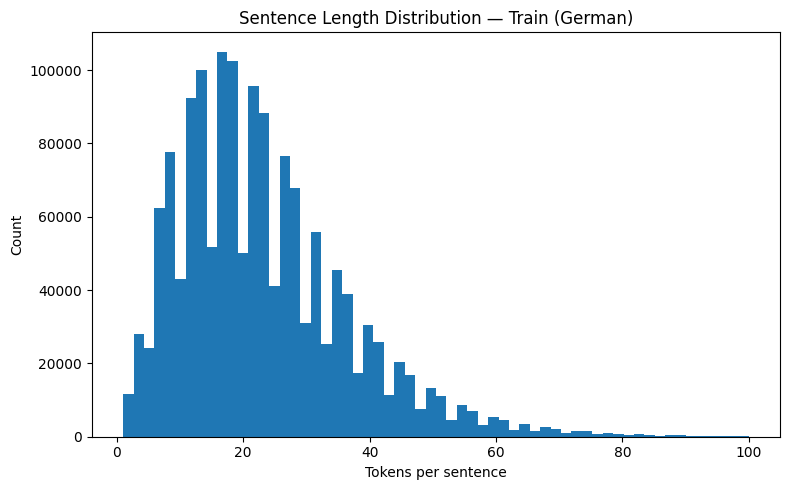

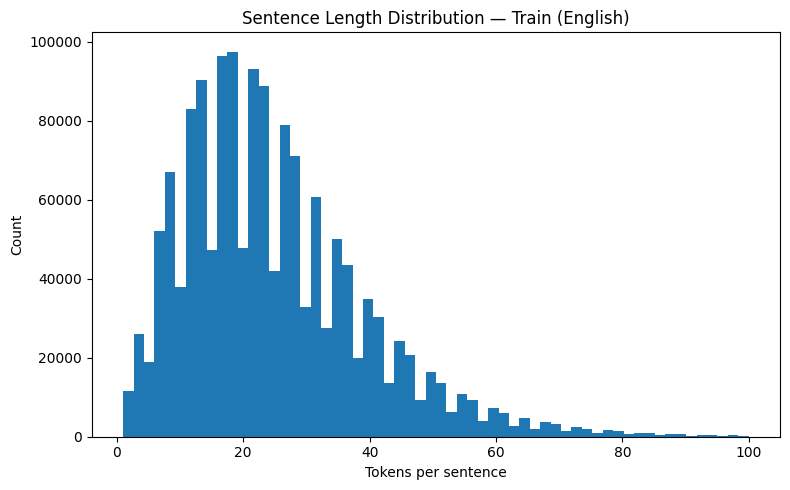

Saved: hist_train_de.png, hist_train_en.png


In [9]:

# ---- paths ----
TRAIN_DE = DATA_DIR / "train.src"   # German (your pipeline uses .src for DE)
TRAIN_EN = DATA_DIR / "train.tgt"   # English (your pipeline uses .tgt for EN)

# ---- load tokenized (or clean) splits ----
de_lines = TRAIN_DE.read_text(encoding="utf-8").splitlines()
en_lines = TRAIN_EN.read_text(encoding="utf-8").splitlines()
assert len(de_lines) == len(en_lines), "Line counts mismatch: train.src vs train.tgt"

# If your files are SentencePiece pieces (e.g., '▁das ▁ist ...'),
# lengths = number of pieces. If they are plain words, same logic works.
def sent_len(s: str) -> int:
    return len(s.strip().split())

de_len = np.array([sent_len(x) for x in de_lines], dtype=int)
en_len = np.array([sent_len(x) for x in en_lines], dtype=int)

# ---- plot histogram (two overlapping outlines not allowed by 'no color' rule),
# so we show them in two separate figures for clarity ----

# German histogram
plt.figure(figsize=(8,5))
plt.hist(de_len, bins=60)
plt.title("Sentence Length Distribution — Train (German)")
plt.xlabel("Tokens per sentence")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("hist_train_de.png", dpi=200)
plt.show()

# English histogram
plt.figure(figsize=(8,5))
plt.hist(en_len, bins=60)
plt.title("Sentence Length Distribution — Train (English)")
plt.xlabel("Tokens per sentence")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("hist_train_en.png", dpi=200)
plt.show()

print("Saved: hist_train_de.png, hist_train_en.png")


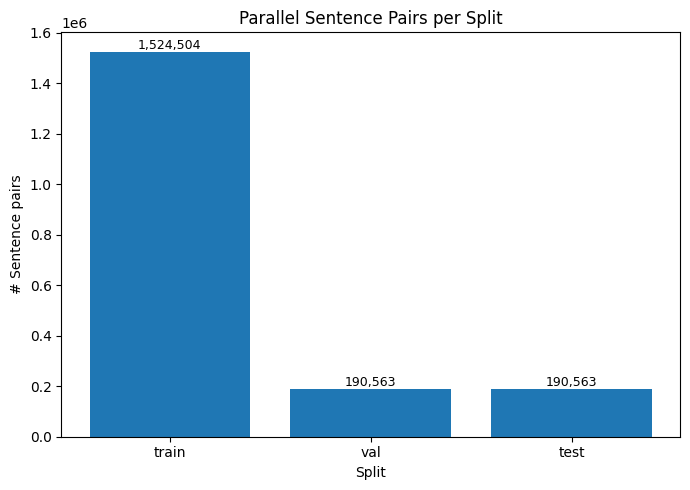

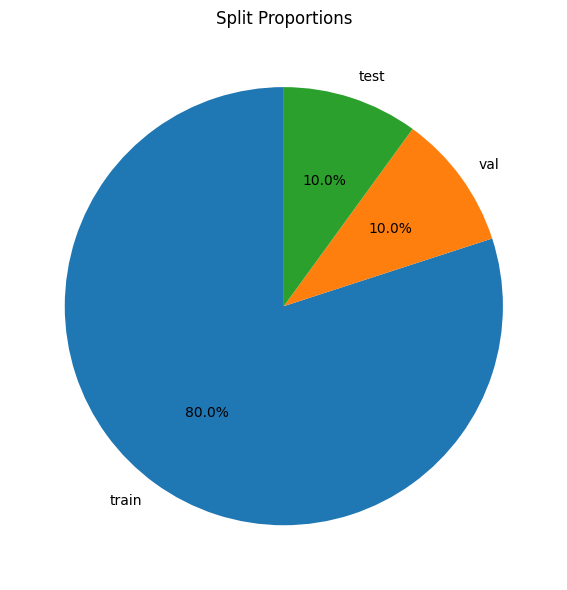

Saved: split_sizes_bar.png, split_sizes_pie.png


In [10]:
def line_count(p: Path) -> int:
    with p.open(encoding="utf-8") as f:
        return sum(1 for _ in f)

splits = ["train", "val", "test"]
sizes  = []
for s in splits:
    n_src = line_count(DATA_DIR / f"{s}.src")
    n_tgt = line_count(DATA_DIR / f"{s}.tgt")
    assert n_src == n_tgt, f"{s}: src ({n_src}) != tgt ({n_tgt})"
    sizes.append(n_src)

# --- Bar chart (one figure) ---
plt.figure(figsize=(7,5))
plt.bar(splits, sizes)
plt.title("Parallel Sentence Pairs per Split")
plt.xlabel("Split")
plt.ylabel("# Sentence pairs")
for i, v in enumerate(sizes):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig("split_sizes_bar.png", dpi=200)
plt.show()

# --- Pie chart (separate figure) ---
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=splits, autopct="%1.1f%%", startangle=90)
plt.title("Split Proportions")
plt.tight_layout()
plt.savefig("split_sizes_pie.png", dpi=200)
plt.show()

print("Saved: split_sizes_bar.png, split_sizes_pie.png")


In [11]:
# raw files (before cleaning/tokenization)
RAW_DE = DATA_DIR / "europarl-v7.de-en.de"
RAW_EN = DATA_DIR / "europarl-v7.de-en.en"

# cleaned split files (after your preprocessing)
CLEAN_DE = DATA_DIR / "train.src"
CLEAN_EN = DATA_DIR / "train.tgt"

# optional tokenized files (after SentencePiece)
SPM_DE = DATA_DIR / "train.spm.src"
SPM_EN = DATA_DIR / "train.spm.tgt"

def clean_text(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

# Find a raw pair that is non-empty and short (so it displays nicely)
with RAW_DE.open(encoding="utf-8") as f_de, RAW_EN.open(encoding="utf-8") as f_en:
    raw_de_lines = f_de.read().splitlines()
    raw_en_lines = f_en.read().splitlines()

assert len(raw_de_lines) == len(raw_en_lines), "Raw DE/EN line counts mismatch"

# choose a random index with short lines
candidates = []
for i, (d, e) in enumerate(zip(raw_de_lines, raw_en_lines)):
    if d.strip() and e.strip() and len(d.split()) < 15 and len(e.split()) < 15:
        candidates.append(i)
random.seed(42)
idx = random.choice(candidates) if candidates else 0

raw_de = raw_de_lines[idx]
raw_en = raw_en_lines[idx]
cln_de = clean_text(raw_de)
cln_en = clean_text(raw_en)

display_block = [
    f"[Index {idx}]",
    "— RAW —",
    f"DE: {raw_de}",
    f"EN: {raw_en}",
    "",
    "— CLEANED —",
    f"DE: {cln_de}",
    f"EN: {cln_en}",
]

# Optionally show tokenized versions if present
if SPM_DE.is_file() and SPM_EN.is_file():
    spm_de_line = (SPM_DE.read_text(encoding="utf-8").splitlines() or [""])[0]
    spm_en_line = (SPM_EN.read_text(encoding="utf-8").splitlines() or [""])[0]
    display_block += [
        "",
        "— TOKENIZED (SentencePiece example lines) —",
        f"DE(spm): {spm_de_line}",
        f"EN(spm): {spm_en_line}",
    ]

print("\n".join(display_block))

[Index 1466954]
— RAW —
DE: Das sind die Fragen, die wir beantworten müssen.
EN: These are the questions we need to answer.

— CLEANED —
DE: das sind die fragen, die wir beantworten müssen.
EN: these are the questions we need to answer.

— TOKENIZED (SentencePiece example lines) —
DE(spm): ▁die ▁vor red ner ▁haben ▁die ▁lage ▁hin reichend ▁besch rieben , ▁eine ▁bess erung ▁für ▁die ▁menschen ▁ist ▁nicht ▁ab zus ehen .
EN(spm): ▁the ▁previous ▁speakers ▁have ▁describ ed ▁the ▁situation ▁ade qu ately : ▁there ▁is ▁no ▁improvement ▁in ▁s ight ▁for ▁the ▁people ▁there .


# Tokenization

In [12]:
VOCAB_SIZE = 8000
MODEL_PREFIX = DATA_DIR/"spm_bpe"

joint = DATA_DIR/"train_joint.txt"
with open(joint,"w",encoding="utf-8") as out:
    out.write((DATA_DIR/"train.src").read_text(encoding="utf-8"))
    out.write((DATA_DIR/"train.tgt").read_text(encoding="utf-8"))

spm.SentencePieceTrainer.Train(
    input=str(joint),
    model_prefix=str(MODEL_PREFIX),
    vocab_size=VOCAB_SIZE,
    model_type="bpe",
    character_coverage=1.0,
    pad_id=0, bos_id=1, eos_id=2, unk_id=3
)
print("SPM trained:", MODEL_PREFIX.with_suffix(".model"))

SPM trained: /content/drive/MyDrive/DL Final Project/data/europarl/spm_bpe.model


In [13]:
sp = spm.SentencePieceProcessor(); sp.Load(str(MODEL_PREFIX)+".model")

def encode_to_new(in_path: Path, out_path: Path):
    with in_path.open(encoding="utf-8") as fin, out_path.open("w",encoding="utf-8") as fout:
        for line in fin:
            ids = sp.encode(line.strip(), out_type=int)   # ids include BOS/EOS if you add; we’ll add during batching/inference
            # here we keep pieces; ids also fine. choose one format and stay consistent.
            pieces = sp.encode(line.strip(), out_type=str)
            fout.write(" ".join(pieces)+"\n")

for split in ["train","val","test"]:
    encode_to_new(DATA_DIR/f"{split}.src", DATA_DIR/f"{split}.spm.src")
    encode_to_new(DATA_DIR/f"{split}.tgt", DATA_DIR/f"{split}.spm.tgt")

print("Encoded → .spm.src/.spm.tgt")


Encoded → .spm.src/.spm.tgt


In [15]:
# Path to your trained SentencePiece model
MODEL_PATH = Path("/content/drive/MyDrive/DL Final Project/data/europarl/spm_bpe.model")

# Load tokenizer
sp = spm.SentencePieceProcessor()
sp.load(str(MODEL_PATH))

# Pick a few example words or phrases (German + English)
examples = [
    "automatisch",         # German word (auto + matisch)
    "wunderbar",           # another German word (wunder + bar)
    "widerstandsfähig",    # complex compound
    "Neural Machine Translation",
    "widening",
    "größten"
]

for text in examples:
    tokens = sp.encode(text, out_type=str)
    print(f"{text}  --->  {tokens}")


automatisch  --->  ['▁automat', 'isch']
wunderbar  --->  ['▁w', 'under', 'bar']
widerstandsfähig  --->  ['▁wider', 'stand', 's', 'fähig']
Neural Machine Translation  --->  ['▁', 'N', 'e', 'ural', '▁', 'M', 'ach', 'ine', '▁', 'T', 'r', 'ans', 'l', 'ation']
widening  --->  ['▁w', 'iden', 'ing']
größten  --->  ['▁größten']


# Training

In [16]:
torch.cuda.empty_cache()
print("CUDA available:", torch.cuda.is_available())
x = torch.randn(2048, 2048, device="cuda")
print("GPU test OK:", x.norm().item())

CUDA available: True
GPU test OK: 2047.0123291015625


In [17]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    x = torch.randn(1024, 1024, device="cuda")  # tiny smoke test
    print("CUDA test ok:", x.norm().item() > 0)

CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
CUDA test ok: True


In [18]:
print("cuda available:", torch.cuda.is_available())
print("torch cuda version:", torch.version.cuda)
if torch.cuda.is_available():
    print("device count:", torch.cuda.device_count())
    print("gpu name:", torch.cuda.get_device_name(0))

cuda available: True
torch cuda version: 12.6
device count: 1
gpu name: NVIDIA A100-SXM4-40GB


In [19]:
SPM = str(DATA_DIR/"spm_bpe.model")
sp = spm.SentencePieceProcessor(); sp.Load(SPM)
PAD, BOS, EOS, UNK = sp.pad_id(), sp.bos_id(), sp.eos_id(), sp.unk_id()
VOCAB = sp.get_piece_size()

class SPMDataset(Dataset):
    def __init__(self, src_file, tgt_file, max_len=120):
        self.src = (DATA_DIR/src_file).read_text(encoding="utf-8").splitlines()
        self.tgt = (DATA_DIR/tgt_file).read_text(encoding="utf-8").splitlines()
        assert len(self.src)==len(self.tgt)
        self.max_len = max_len
    def __len__(self): return len(self.src)
    def __getitem__(self, i):
        s_ids = [BOS] + sp.encode(self.src[i], out_type=int)[:self.max_len-2] + [EOS]
        t_ids = [BOS] + sp.encode(self.tgt[i], out_type=int)[:self.max_len-2] + [EOS]
        return torch.tensor(s_ids), torch.tensor(t_ids)

def collate(batch):
    srcs, tgts = zip(*batch)
    Ls = [len(x) for x in srcs]; Lt = [len(x) for x in tgts]
    S = torch.full((len(batch), max(Ls)), PAD, dtype=torch.long)
    T = torch.full((len(batch), max(Lt)), PAD, dtype=torch.long)
    for i,(s,t) in enumerate(zip(srcs,tgts)):
        S[i,:len(s)] = s; T[i,:len(t)] = t
    return S,T, torch.tensor(Ls), torch.tensor(Lt)

train_ds = SPMDataset("train.spm.src","train.spm.tgt", max_len=120)
val_ds   = SPMDataset("val.spm.src","val.spm.tgt", max_len=120)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate)
val_dl   = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate)

In [20]:
import torch.nn.functional as F

class Enc(nn.Module):
    def __init__(self, V, E=256, H=512):
        super().__init__()
        self.emb = nn.Embedding(V, E, padding_idx=PAD)
        self.rnn = nn.LSTM(E, H, num_layers=2, batch_first=True, bidirectional=True)
        self.H = H
    def forward(self, x, lens):
        e = self.emb(x)
        pack = nn.utils.rnn.pack_padded_sequence(e, lens.cpu(), batch_first=True, enforce_sorted=False)
        out, (h,c) = self.rnn(pack)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        # concat bidi
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        c = torch.cat([c[0:c.size(0):2], c[1:c.size(0):2]], dim=2)
        return out, (h,c)

class Luong(nn.Module):
    def __init__(self, H): super().__init__(); self.W = nn.Linear(H, H, bias=False)
    def forward(self, q, K, V, mask):
        score = torch.bmm(self.W(q).unsqueeze(1), K.transpose(1,2)).squeeze(1)
        score.masked_fill_(mask, -1e9)
        attn = score.softmax(-1)
        ctx = torch.bmm(attn.unsqueeze(1), V).squeeze(1)
        return ctx, attn

class Dec(nn.Module):
    def __init__(self, V, E=256, H=1024):  # H doubled (bidi)
        super().__init__()
        self.emb = nn.Embedding(V, E, padding_idx=PAD)
        self.attn = Luong(H)
        self.rnn = nn.LSTM(E+H, H, num_layers=2, batch_first=True)
        self.fc  = nn.Linear(H+H, V)
        self.H = H
    def forward(self, y_prev, hidden, enc_out, src_mask):
        e = self.emb(y_prev)          # [B,1,E]
        q = hidden[0][-1]             # top layer hidden [B,H]
        ctx, _ = self.attn(q, enc_out, enc_out, src_mask)
        rnn_in = torch.cat([e, ctx.unsqueeze(1)], dim=2)
        out, hidden = self.rnn(rnn_in, hidden)   # out:[B,1,H]
        logits = self.fc(torch.cat([out.squeeze(1), ctx], dim=1))
        return logits, hidden

class Seq2Seq(nn.Module):
    def __init__(self, V, E=256, H=512):
        super().__init__()
        self.enc = Enc(V,E,H)
        self.dec = Dec(V,E,H*2)
    def mask(self, x): return (x==PAD)
    def forward(self, src, src_lens, tgt, teacher=0.5):
        B,T = tgt.size()
        enc_out, hid = self.enc(src, src_lens)
        m = self.mask(src)
        y = tgt[:,0].unsqueeze(1)        # BOS
        outs = []
        for t in range(1,T):
            logits, hid = self.dec(y, hid, enc_out, m)
            outs.append(logits.unsqueeze(1))
            use_teacher = torch.rand(1).item() < teacher
            next_tok = tgt[:,t] if use_teacher else logits.argmax(-1)
            y = next_tok.unsqueeze(1)
        return torch.cat(outs,1)
    def decode(self, src, src_lens, max_len=120):
        enc_out, hid = self.enc(src, src_lens)
        m = self.mask(src)
        y = torch.full((src.size(0),1), BOS, dtype=torch.long, device=src.device)
        outs = [y]
        for _ in range(max_len):
            logits, hid = self.dec(y, hid, enc_out, m)
            y = logits.argmax(-1, keepdim=True)
            outs.append(y)
            if (y.squeeze(1)==EOS).all(): break
        return torch.cat(outs,1)


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Seq2Seq(VOCAB).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

for epoch in range(1, 6):
    model.train(); tot=0
    for S,T,Ls,Lt in tqdm(train_dl, desc=f"epoch {epoch}"):
        S,T,Ls,Lt = S.to(device),T.to(device),Ls.to(device),Lt.to(device)
        logits = model(S, Ls, T, teacher=0.5)            # [B, T-1, V]
        loss = loss_fn(logits.reshape(-1, VOCAB), T[:,1:].reshape(-1))
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); tot += loss.item()
    print("train loss:", tot/len(train_dl))


epoch 1: 100%|██████████| 23821/23821 [2:01:47<00:00,  3.26it/s]


train loss: 3.842918460092168


epoch 2: 100%|██████████| 23821/23821 [2:03:59<00:00,  3.20it/s]


train loss: 3.3038610519467473


epoch 3: 100%|██████████| 23821/23821 [2:03:20<00:00,  3.22it/s]


train loss: 2.8452309226965724


epoch 4: 100%|██████████| 23821/23821 [2:06:05<00:00,  3.15it/s]


train loss: 2.668655970871166


epoch 5: 100%|██████████| 23821/23821 [2:03:50<00:00,  3.21it/s]

train loss: 2.581710770760609


# Evaluation

In [23]:
import sacrebleu as scb
from pathlib import Path

model.eval()
all_h, all_r = [], []

with torch.no_grad():
    for S, T, Ls, _ in tqdm(val_dl, desc="eval"):
        S, T, Ls = S.to(device), T.to(device), Ls.to(device)
        out = model.decode(S, Ls, max_len=120)  # ids with BOS/EOS

        # go over each sentence pair in the batch
        for hyp_ids, ref_ids in zip(out, T):

            # strip PAD / BOS / EOS
            def strip(ids):
                ids = [int(i) for i in ids]
                cleaned = []
                for i in ids:
                    if i in (PAD, BOS):
                        continue
                    if i == EOS:
                        break
                    cleaned.append(i)
                return cleaned

            hyp_txt = sp.decode_ids(strip(hyp_ids.tolist()))
            ref_txt = sp.decode_ids(strip(ref_ids.tolist()))
            all_h.append(hyp_txt)
            all_r.append(ref_txt)

# ---- BLEU score ----
bleu = scb.corpus_bleu(all_h, [all_r]).score
print(f"BLEU: {bleu:.2f}")

# ---- save some pretty samples ----
out_dir = Path("outputs")
out_dir.mkdir(parents=True, exist_ok=True)   # <-- create folder if missing

samples = []
for i in range(min(30, len(all_h))):
    samples.append(f"HYP: {all_h[i]}\nREF: {all_r[i]}\n")

(out_dir / "samples.txt").write_text("\n".join(samples), encoding="utf-8")
print("saved →", out_dir / "samples.txt")


eval: 100%|██████████| 2978/2978 [06:59<00:00,  7.10it/s]


BLEU: 30.71
saved → outputs/samples.txt


In [24]:
Path("checkpoints").mkdir(exist_ok=True)

torch.save(model.state_dict(), "checkpoints/seq2seq_europarl_final.pth")
print("Saved model → checkpoints/seq2seq_europarl_final.pth")


Saved model → checkpoints/seq2seq_europarl_final.pth


In [31]:
CKPT_DIR = "/content/drive/MyDrive/DL Final Project/checkpoints"
!cp checkpoints/seq2seq_europarl_final.pth "{CKPT_DIR}"

In [32]:
!ls "/content/drive/MyDrive/DL Final Project/checkpoints"


seq2seq_europarl_final.pth
